# Analyse des données de systèmes éducatifs
Etude data - Projet 2 Nalron (Septembre 2020) OpenClassrooms / CentraleSupélec\
Traitement des données sur Jupyter Notebook (Distribution Anaconda)\
Etude réalisée en langage Python/

Data source : [Données de la Banque mondiale](https://datacatalog.worldbank.org/dataset/education-statistics)

---

## ACP et clustering k-means 
Rappelons les objectifs de l'entreprise, l'internationalisation des services de cours en ligne. Un choix de pays cibles devra être fait, l'aide à la décision qui passe par l'étude actuelle repose sur des hypothèses que nous poserons prochainement. La classification des pays par l'algortithme k-means semble être le bon choix de modélisation, en effet le k-means permet de rechercher efficacement une partition des données dont la variance intra-cluster est minimale. 

In [82]:
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition

In [83]:
X = df_indicators.iloc[:, 2:].values

In [84]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

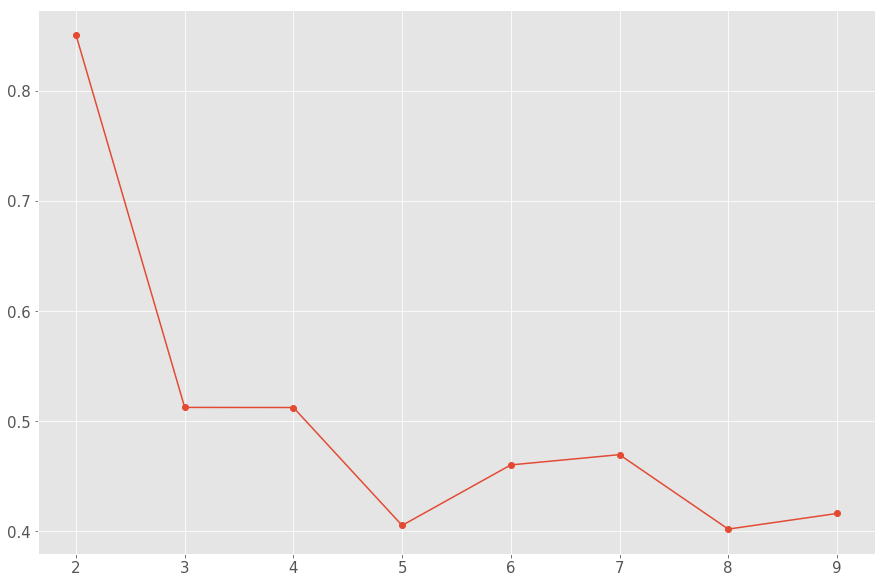

In [85]:
silhouettes = [] 

for k in range(2, 10):
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

Notons que le coefficient de silhouette k=3 semble pertinent pour la réalisation du clustering, ce coefficient de silhouette n'est pas le plus élevé, mais fera ressortir des patterns plus appropiés aux objectifs attendus. De plus, k=3 ou k=4 fera très certainement ressortir des pays à forte inertie (type Chine, USA…). Le contexte métier semble favorable à un partitionnement dans lequel des fortes puissances seraient isolées pour ne pas influencer les zones dont l'inertie serait bien moins importante _(nous le verrons plus loin dans l'analyse).

In [86]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

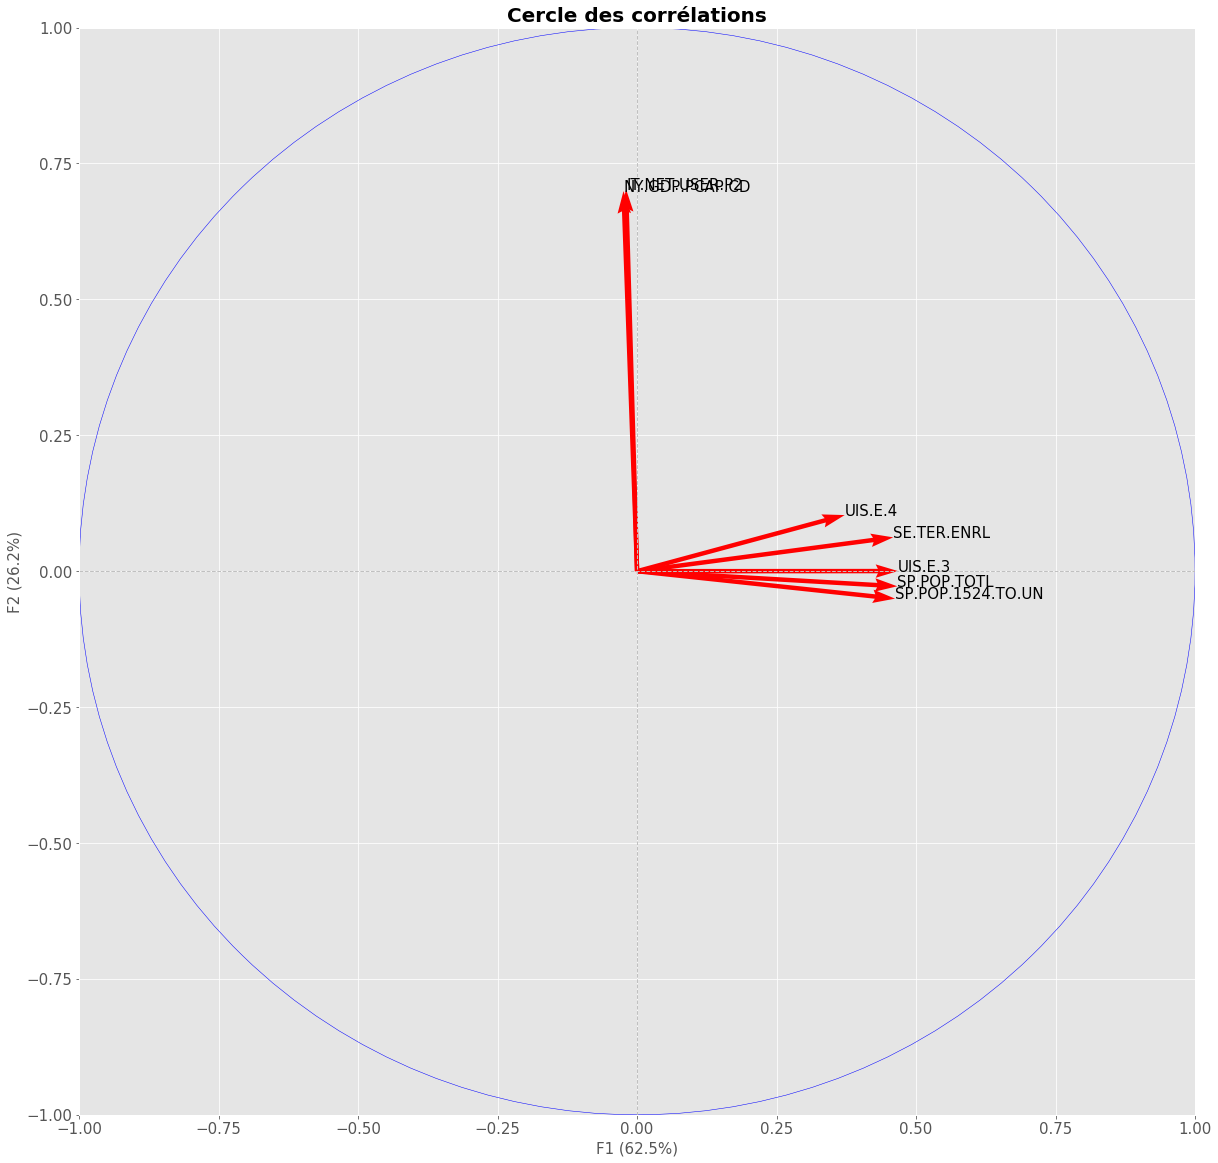

In [87]:
pc = pca.components_

fig = plt.subplots(figsize=(20,20))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pc.shape[1]), np.zeros(pc.shape[1]),
           pc[0,:], pc[1,:], 
           angles='xy', scale_units='xy', scale=1, color='r', width= 0.004)

for i, (x, y) in enumerate(zip(pc[0, :], pc[1, :])):
    plt.text(x, y, df_indicators.iloc[:, 2:].columns[i], fontsize=15)
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations', fontsize=20)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.savefig("p2_00_graphic/cercle_correlation.png")
plt.show()

In [88]:
print(pca.explained_variance_ratio_.cumsum())

[0.62510885 0.8874847  0.96036348 0.98660659]


Notons que plus de 88% de la variance expliquée se retrouve dans les deux premières composantes principales.

In [89]:
cls = cluster.KMeans(n_clusters=4)
cls.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [90]:
clusters_kmeans = cls.labels_

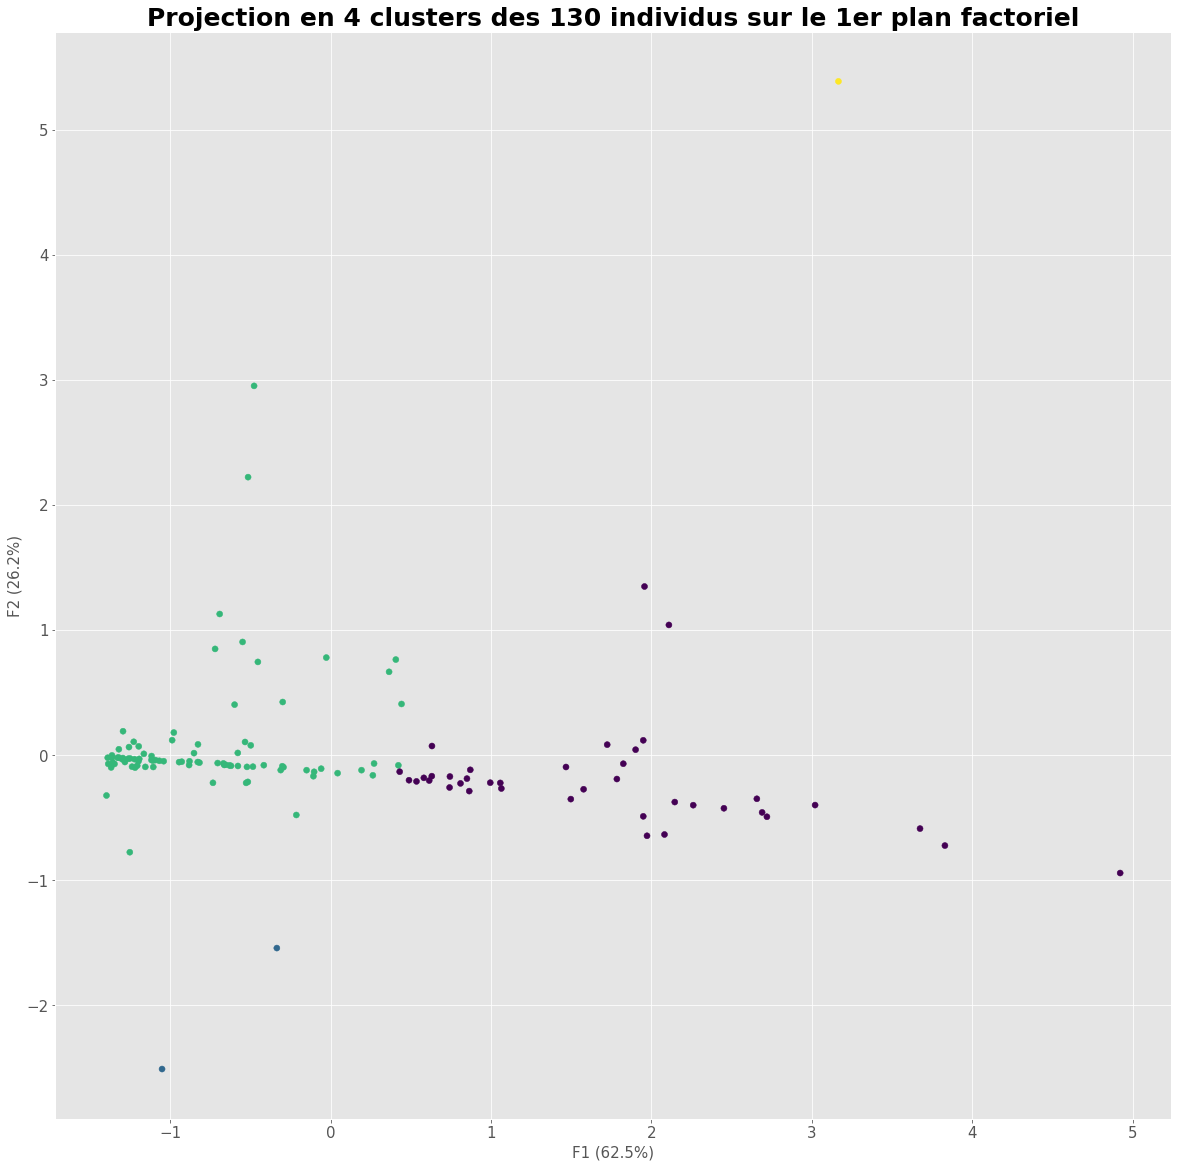

In [91]:
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 20))

plt.scatter(X_projected[:, 1], X_projected[:, 2], c=cls.labels_)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 4 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('p2_00_graphic/pca_projection.png')
plt.show()

In [92]:
centroids = cls.cluster_centers_
pd.DataFrame(centroids, columns=indicators, index=['cluster0', 'cluster1', 'cluster2', 'cluster3'])

,IT.NET.USER.P2,NY.GDP.PCAP.CD,SP.POP.TOTL,SP.POP.1524.TO.UN,UIS.E.3,UIS.E.4,SE.TER.ENRL
cluster0,1.258389,1.171855,-0.136778,-0.188526,-0.158090,-0.122061,-0.140692
cluster1,-0.664201,-0.609345,6.374361,7.724582,7.700869,7.583737,3.920354
cluster2,-0.560206,-0.523231,-0.146370,-0.107063,-0.123830,-0.143614,-0.110156
cluster3,1.549379,1.560635,5.466174,1.324915,1.660805,2.230974,7.340002


In [93]:
idk = np.argsort(cls.labels_)

df_cls = pd.DataFrame(df_indicators.index[idk], cls.labels_[idk]).reset_index()
df_cls = df_cls.rename(columns={'index':'cluster'})

In [94]:
df_cls = pd.merge(df_indicators, df_cls, on='Country Name')
display(df_cls.shape)
display(df_cls.head())

(130, 11)

,Country Name,Country Code,Currency Unit,IT.NET.USER.P2,NY.GDP.PCAP.CD,SE.TER.ENRL,SP.POP.1524.TO.UN,SP.POP.TOTL,UIS.E.3,UIS.E.4,cluster
0,Afghanistan,AFG,Afghan afghani,38.178801,5504.733085,509422.0,81269137.0,396801806.0,6129824.0,561081.0,2
1,Albania,ALB,Albanian lek,365.928222,47836.417233,1393260.0,8737415.0,44618462.0,2167444.0,3778.0,2
2,Andorra,AND,Euro,806.500709,567066.339642,3633.0,54179.0,1173712.0,13692.0,3612.0,0
3,Antigua and Barbuda,ATG,East Caribbean dollar,528.556704,177271.659708,5067.0,77883.0,1371307.0,17940.0,9638.0,2
4,Aruba,ABW,Aruban florin,657.122823,280141.788190,28915.0,193343.0,1492667.0,50000.0,124.0,0


In [95]:
print(str(len(df_cls[df_cls['cluster'] == 0]['Country Name'])) + " pays dans le cluster 0")
print(str(len(df_cls[df_cls['cluster'] == 1]['Country Name'])) + " pays dans le cluster 1")
print(str(len(df_cls[df_cls['cluster'] == 2]['Country Name'])) + " pays dans le cluster 2")
print(str(len(df_cls[df_cls['cluster'] == 3]['Country Name'])) + " pays dans le cluster 3")

39 pays dans le cluster 0
2 pays dans le cluster 1
88 pays dans le cluster 2
1 pays dans le cluster 3


In [96]:
#Checklist countries from cluster 0
df_cls0 = df_cls[df_cls['cluster'] == 0]['Country Name'].unique()
df_cls0

array(['Andorra', 'Aruba', 'Australia', 'Austria', 'Bahrain', 'Barbados',
       'Belgium', 'Brunei Darussalam', 'Canada', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Hong Kong SAR, China', 'Iceland', 'Ireland', 'Israel',
       'Italy', 'Japan', 'Kuwait', 'Latvia', 'Liechtenstein',
       'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [97]:
np.intersect1d(df_cls0, country_evolution['Country Name'].unique())

array(['Aruba', 'Australia', 'Austria', 'Bahrain', 'Belgium', 'Canada',
       'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Hong Kong SAR, China', 'Iceland', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Kuwait', 'Latvia', 'Luxembourg',
       'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Portugal',
       'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [98]:
#Cluster 1
df_cls1 = df_cls[df_cls['cluster'] == 1]['Country Name'].unique()
df_cls1

array(['China', 'India'], dtype=object)

In [99]:
#Cluster 2
df_cls2 = df_cls[df_cls['cluster'] == 2]['Country Name'].unique()
df_cls2

array(['Afghanistan', 'Albania', 'Antigua and Barbuda', 'Azerbaijan',
       'Bangladesh', 'Belarus', 'Belize', 'Bhutan', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Cayman Islands', 'Chad', 'Colombia', 'Comoros', 'Cuba',
       'Djibouti', 'Egypt, Arab Rep.', 'Eritrea', 'Ethiopia', 'Fiji',
       'Gambia, The', 'Georgia', 'Ghana', 'Greece', 'Grenada', 'Guyana',
       'Hungary', 'Iran, Islamic Rep.', 'Iraq', 'Jamaica', 'Kazakhstan',
       'Kenya', 'Kyrgyz Republic', 'Lao PDR', 'Lebanon', 'Lesotho',
       'Liberia', 'Lithuania', 'Madagascar', 'Malawi', 'Malaysia',
       'Maldives', 'Mali', 'Mauritania', 'Mauritius', 'Moldova',
       'Mongolia', 'Morocco', 'Namibia', 'Nicaragua', 'Niger', 'Oman',
       'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'Seychelles',
       'Sierra Leone', 'South Africa', 'Sri Lanka', 'St. Kitts and Nevis',
       'St

In [100]:
#Interaction with "country_evolution"
np.intersect1d(df_cls2, country_evolution['Country Name'].unique())

array(['Albania', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belize',
       'Bhutan', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Chad', 'Colombia', 'Comoros', 'Cuba',
       'Egypt, Arab Rep.', 'Ethiopia', 'Gambia, The', 'Georgia', 'Ghana',
       'Greece', 'Guyana', 'Hungary', 'Iran, Islamic Rep.', 'Iraq',
       'Jamaica', 'Kazakhstan', 'Kenya', 'Kyrgyz Republic', 'Lao PDR',
       'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Madagascar',
       'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Mauritius', 'Moldova',
       'Mongolia', 'Morocco', 'Namibia', 'Nicaragua', 'Niger', 'Pakistan',
       'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania',
       'Russian Federation', 'Rwanda', 'Samoa', 'Sierra Leone',
       'South Africa', 'St. Lucia', 'Suriname', 'Swaziland',
       'Syrian Arab Republic', 'Tanzania', 'Thailand', 'Tonga',
       'Trinidad and Tobago', 'Tunisia', 'Uganda', 'Ukraine', 'Uruguay',
       'Vanuatu', 'West Bank an

In [101]:
#Cluster 3
df_cls3 = df_cls[df_cls['cluster'] == 3]['Country Name'].unique()
df_cls3

array(['United States'], dtype=object)

In [102]:
di = np.sum(X_scaled**2,axis=1)
ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'Country Name': df_cls['Country Name'], 
                                  'Country Code': df_cls['Country Code'],
                                  'Currency Unit': df_cls['Currency Unit'],
                                  'cluster': df_cls['cluster']}).sort_values(by='c_inertie', ascending=False)

ctr_indiv_inertie = ctr_indiv_inertie[ctr_indiv_inertie['cluster'] == 0]
ctr_indiv_inertie['rank'] = ctr_indiv_inertie['c_inertie'].rank(ascending=False)
ctr_indiv_inertie


,c_inertie,Country Name,Country Code,Currency Unit,cluster,rank
68,32.400587,Liechtenstein,LIE,Swiss franc,0,1.0
70,17.659858,Luxembourg,LUX,Euro,0,2.0
87,14.513534,Norway,NOR,Norwegian krone,0,3.0
114,9.761808,Switzerland,CHE,Swiss franc,0,4.0
50,8.279202,Iceland,ISL,Iceland krona,0,5.0
32,8.092809,Denmark,DNK,Danish krone,0,6.0
113,7.638824,Sweden,SWE,Swedish krona,0,7.0
43,7.247820,Germany,DEU,Euro,0,8.0
83,6.589247,Netherlands,NLD,Euro,0,9.0
5,6.285542,Australia,AUS,Australian dollar,0,10.0


In [103]:
di = np.sum(X_scaled**2,axis=1)
ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'Country Name': df_cls['Country Name'], 
                                  'Country Code': df_cls['Country Code'],
                                  'Currency Unit': df_cls['Currency Unit'],
                                  'cluster': df_cls['cluster']}).sort_values(by='c_inertie', ascending=False)

ctr_indiv_inertie = ctr_indiv_inertie[ctr_indiv_inertie['cluster'] == 2]
ctr_indiv_inertie['rank'] = ctr_indiv_inertie['c_inertie'].rank(ascending=False)
ctr_indiv_inertie

,c_inertie,Country Name,Country Code,Currency Unit,cluster,rank
93,13.473581,Philippines,PHL,Philippine peso,2,1.0
52,9.594084,"Iran, Islamic Rep.",IRN,Iranian rial,2,2.0
98,6.725724,Russian Federation,RUS,Russian ruble,2,3.0
16,5.457240,Brazil,BRA,Brazilian real,2,4.0
9,3.883976,Bangladesh,BGD,Bangladeshi taka,2,5.0
89,3.302816,Pakistan,PAK,Pakistani rupee,2,6.0
35,2.374716,Eritrea,ERI,Eritrean nakfa,2,7.0
86,2.304426,Niger,NER,CFA franc,2,8.0
67,2.297960,Liberia,LBR,Liberian dollar,2,9.0
37,2.286494,Ethiopia,ETH,Ethiopian birr,2,10.0


### Nos groupes sont-ils réellement distincts? 

**Test d'adéquation de Kolmogorov-Smirnov :**
On peut tester l’adéquation de la variable 'IT.NET.USER.P2' à une loi normale à l’aide de *Kolmogorov-Smirnov*. 

In [104]:
from scipy.stats import ks_2samp

stat, p = ks_2samp(df_indicators['IT.NET.USER.P2'],
          list(np.random.normal(np.mean(df_indicators['IT.NET.USER.P2']), 
          np.std(df_indicators['IT.NET.USER.P2']), 1000)))
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.03
if p > alpha:
    print('On ne peut pas rejeter H0 pour des niveaux de test de 3%')
else:
    print('H0 est rejetée à un niveau de test de 3%')

Statistics=0.122, p=0.060
On ne peut pas rejeter H0 pour des niveaux de test de 3%


Le test de Kolmogorov-Smirnov répond positivement à une loi normale. 

**Test de comparaison de deux clusters dans le cas gaussien.**

In [105]:
cluster_test1 = df_cls[df_cls['cluster'] == 2]['IT.NET.USER.P2']
cluster_test2 = df_cls[df_cls['cluster'] == 0]['IT.NET.USER.P2']

In [106]:
from scipy.stats import bartlett
stat, p = bartlett(cluster_test1, cluster_test2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('On ne rejette donc pas H0, l’égalité des variances au niveau de test 5%')
else:
    print('H0 est rejetée au niveau de test 5%')

Statistics=0.259, p=0.611
On ne rejette donc pas H0, l’égalité des variances au niveau de test 5%


In [107]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(cluster_test1, cluster_test2, equal_var=True)
print('Statistics=%.3f, p=%.9f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('On ne rejette donc pas H0, l’égalité des moyennes de nos 2 clusters au niveau de test 5%')
else:
    print('H0 l\'hypothèse d’égalité des moyennes est rejetée au niveau de test 5%')

Statistics=-17.344, p=0.000000000
H0 l'hypothèse d’égalité des moyennes est rejetée au niveau de test 5%


**Les tests statistiques réalisés permettent de vérifier que nos clusters ne suivent pas la même distribution, en effet l'hypothèse d'égalité des moyennes a été rejetée dans le cadre du test précédent. Les clusters identifiés sont distincts.**

## Recommandations des pays à clibler…
Ces préconisations tiennent compte des corrélations entre nos variables, comme nous avons pu le voir dans le cercle des corrélations. Pour rappel, il se dégage deux principaux critères _socio-démographique_ et _business_ propre au métier de l'entreprise.

Il n'est pas envisageable de recueillir l'ensemble des pays de ces clusters. La cohérence métier de l'entreprise doit permettre d'affiner les résultats proposés, le bon sens des décideurs permettra la sélection finale. Ceci étant, les premières recommandations sont les suivantes.

**Première solution, un développement "plus rapide" tourné vers l'Union Européenne :**

A partir des hypothèses proposées et de leur représentation dans l'inertie totale, les pays cibles prioritaires seraient : **Liechtenstein, Luxembourg, Norvège, Suisse, Islande, Suisse, Allemagne, (Royaume-Uni).**

Ces pays sont non seulement dans l'Union Européenne (facilité monétaire, culturelle, etc…), et répondent à une position dominante en terme de pouvoir d'achat de la population.

**Seconde solution, un développement en dehors de l'Union Européenne :**

A partir des hypothèses proposées et de leur représentation dans l'inertie totale, les pays cibles seraient : **Canada, Australie, Nouvelle-Zélande, Qatar, Japon.** _A noter également, un potentiel marché à affiner pour la Chine, l'Inde, et les USA._

Ces pays sont plus difficiles d'accès de part leur différence culturelle, une barrière linguistique possible, mais répondent à un potentiel métier intéressant. 

**Autre solution prenant en compte une perspective d'évolution sur d'ici 2030 :**

Très fort potentiel pour la **Chine, l'Inde, et les USA**. Ceci étant, les pays suivants, avec une pénétration marché plus facile, seraient à travailler pour un positionnement d'ici 2030 : **Allemagne, Royaume-Uni, Canada, Japon.**

Quelque soit la ou les décisions d'internalisation de l'entreprise, ces critères sont issus d'une réflexion globale tenant compte de critère sociaux démographiques, technologiques et métiers. ***L'analyse n'exclue pas une étude complémentaire portant sur les contraintes concurrentielle avant le lancement d'une plateforme hors France, surtout pour des pays comme la Chine, l'Inde et les USA.***

In [108]:
import folium
from branca.element import Figure

# Creating Basemap
fig=Figure(width=950,height=550)
m=folium.Map(location=[38.9597594,34.9249653], tiles='cartodbpositron',zoom_start=2)
fig.add_child(m)

###PRIORITY TARGET COUNTRIES
#LIECHTENSTEIN
folium.Marker(location=[47.1416307, 9.5531527],
              popup='<strong>Prioritaire</strong>',
              tooltip='<strong>LIECHTENSTEIN</strong>',
              icon=folium.Icon(color='blue',icon='info-sign')).add_to(m)
#LUXEMBOURG
folium.Marker(location=[49.8158683, 6.1296751],
              popup='<strong>Prioritaire</strong>',
              tooltip='<strong>LUXEMBOURG</strong>',
              icon=folium.Icon(color='blue',icon='info-sign')).add_to(m)
#NORWAY
folium.Marker(location=[64.5731537, 11.5280364],
              popup='<strong>Prioritaire</strong>',
              tooltip='<strong>NORVEGE</strong>',
              icon=folium.Icon(color='blue',icon='info-sign')).add_to(m)
#SWITZERLAND 
folium.Marker(location=[46.7985624, 8.2319736],
              popup='<strong>Prioritaire</strong>',
              tooltip='<strong>SWITZERLAND</strong>',
              icon=folium.Icon(color='blue',icon='info-sign')).add_to(m)
#ICELAND
folium.Marker(location=[64.9841821, -18.1059013],
              popup='<strong>Prioritaire</strong>',
              tooltip='<strong>ICELAND</strong>',
              icon=folium.Icon(color='blue',icon='info-sign')).add_to(m)

#GERMANY
folium.Marker(location=[51.0834196, 10.4234469],
              popup='<strong>Prioritaire</strong>',
              tooltip='<strong>GERMANY</strong>',
              icon=folium.Icon(color='blue',icon='info-sign')).add_to(m)

#UNITED KINGDOM
folium.Marker(location=[54.7023545, -3.2765753],
              popup='<strong>Prioritaire</strong>',
              tooltip='<strong>UNITED KINGDOM</strong>',
              icon=folium.Icon(color='blue',icon='info-sign')).add_to(m)

###NON-PRIORITY TARGET COUNTRIES
#CANADA
folium.Marker(location=[61.0666922, -107.9917071],
              tooltip='<strong>CANADA</strong>',
              icon=folium.Icon(color='orange',icon='info-sign')).add_to(m)

#AUSTRALIA
folium.Marker(location=[-24.7761086, 134.755],
              tooltip='<strong>AUSTRALIA</strong>',
              icon=folium.Icon(color='orange',icon='info-sign')).add_to(m)

#NEW ZEALAND
folium.Marker(location=[-41.5000831, 172.8344077],
              tooltip='<strong>NEW ZEALAND</strong>',
              icon=folium.Icon(color='orange',icon='info-sign')).add_to(m)

#QATAR
folium.Marker(location=[25.3336984, 51.2295295],
              tooltip='<strong>CANADA</strong>',
              icon=folium.Icon(color='orange',icon='info-sign')).add_to(m)

#JAPAN
folium.Marker(location=[36.5748441, 139.2394179],
              tooltip='<strong>JAPAN</strong>',
              icon=folium.Icon(color='orange',icon='info-sign')).add_to(m)


m

![folium](p2_00_image/folium.png)